# Numerical Analysis Final Project: Lasso vs Ridge Regression

In [9]:
import Pkg

In [48]:
Pkg.add("StatsPlots")

   Resolving package versions...
   Installed IntelOpenMP_jll ─── v2018.0.3+2
   Installed Rmath_jll ───────── v0.3.0+0
   Installed PDMats ──────────── v0.11.7
   Installed StatsFuns ───────── v0.9.18
   Installed FFTW ────────────── v1.4.6
   Installed OffsetArrays ────── v1.10.8
   Installed NearestNeighbors ── v0.4.10
   Installed Ratios ──────────── v0.4.3
   Installed MKL_jll ─────────── v2022.0.0+0
   Installed StatsPlots ──────── v0.14.33
   Installed FFTW_jll ────────── v3.3.10+0
   Installed Widgets ─────────── v0.6.5
   Installed KernelDensity ───── v0.6.3
   Installed Rmath ───────────── v0.7.0
   Installed AbstractFFTs ────── v1.1.0
   Installed MultivariateStats ─ v0.9.1
   Installed Arpack_jll ──────── v3.5.1+1
   Installed QuadGK ──────────── v2.4.2
   Installed Arpack ──────────── v0.5.3
   Installed AxisAlgorithms ──── v1.0.1
   Installed TableOperations ─── v1.2.0
   Installed WoodburyMatrices ── v0.5.5
   Installed FillArrays ──────── v0.13.2
   Installed DensityInt

In [10]:
Pkg.add("Pandas")
Pkg.add("LinearAlgebra")
Pkg.add("CSV")
Pkg.add("Statistics")
Pkg.add("Plots")
Pkg.add("DataFrames")

    Updating registry at `C:\Users\Kingston\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\Kingston\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\Kingston\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Kingston\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\Kingston\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Kingston\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\Kingston\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Kingston\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\Kingston\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Kingston\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\Kingston\.julia\environments\v1.7\Manifest.toml`
   Resolving p

In [49]:
using Pkg
using Pandas
using LinearAlgebra
using DataFrames
using CSV
using Statistics
using Plots
using StatsPlots

## Import data

---

In [12]:
matrix_data_temp = CSV.File("median_housing_cost_data.tsv") |> Tables.matrix
matrix_data = matrix_data_temp[:,2:9];

In [13]:
matrix_target_temp = CSV.File("housing_cost_targets.tsv") |> Tables.matrix
matrix_target = matrix_target_temp[:,2];

In [14]:
# train test split (test proportion of 20%) - test has 4128 samples, train has 16512 samples

matrix_data_train = matrix_data[1:16512, :];
matrix_data_test = matrix_data[16513:20640, :];

matrix_target_train = matrix_target[1:16512, :];
matrix_target_test = matrix_target[16513:20640, :];

In [15]:
# normalize data (min max normalize)
# comment this out and run cell above if we wish to do it without normalizing

for i in 1:size(matrix_data_train)[2]
    
    matrix_data_train[:,i] = (matrix_data_train[:,i] .- findmin(matrix_data_train[:,i])[1]) ./ (findmax(matrix_data_train[:,i])[1] - findmin(matrix_data_train[:,i])[1]);
    matrix_data_test[:,i] = (matrix_data_test[:,i] .- findmin(matrix_data_test[:,i])[1]) ./ (findmax(matrix_data_test[:,i])[1] - findmin(matrix_data_test[:,i])[1]);

end

matrix_target_train = (matrix_target_train .- findmin(matrix_target_train)[1]) ./ (findmax(matrix_target_train)[1] - findmin(matrix_target_train)[1]);
matrix_target_test = (matrix_target_test .- findmin(matrix_target_test)[1]) ./ (findmax(matrix_target_test)[1] - findmin(matrix_target_test)[1]);

## Motivating Factor

------

Our motivating factor for our project is to address the lack of accuracy for real estate valuation, and to modernize the real estate sector. Due to the high fees of appraisers and the inconsistent valuations of homes, *we would like to streamline the process of determining house value and provide a base asking price for sellers to feel comfortable valuating their homes.* 

In our project, we implemented two linear regression methodologies (*Ridge Regression and Lasso Regression*) to create different ways of calculating the price of a home given certain characteristics. These two regressions can be used as machine learning algorithms to provide a great estimate on the cost of a home. Our goal for our algorithms is to determine which is better suited for our data. We will consider our models' accuracy, conditioning, algorithmic complexities, and number of floating point operations.

### Technical Goals

---

Our ultimate goal from our machine learning models is to "maximize posterior probabilities" in order to produce the most likely prediction of the cost of a house in the real world. A "posterior probability" is a calculation of whether something is true in relation to previous observations.

We would like to find the arguments 𝑤 (linear regression parameters) which maximize the posterior probability of
our outcomes. This formulation comes from a Bayesian approach called Maximum A Posteriori (MAP) that multiplies the
probability of a data likelihood by its prior probability to get the posterior we are attempting to maximize. 

We have derived the MAP approaches into linear regression tasks with closed form solutions. The distributions of the
data likelihoods and prior probabilities dictate the type of regression we will use. From our solutions, we show that data likelihood and prior probabilities both following Gaussian distributions result in ridge regression. We also show that data 
likelihood following a Gaussian distribution and prior probabilities following a Poisson distribution result in lasso regression.

### Our Data
---

##### Note: Our dataset is based off of US Census Data and is a dataset which is built into Python's popular SKLearn Library.

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html

##### Samples: 20,640
##### Dimensionality: 8
#### Features: 
- Median Income
- House Age
- Number of Rooms / House
- Block Group Population
- Number of Bedrooms
- Occupancy
- Latitude
- Longitude
- Median House Price **(Target)**

------

## Regression Tasks Derived from Maximizing Posterior Probabilities

------

Here we will derive from the Bayesian approach of maximizing w on a posterior probability the corresponding regression task:

#### Deriving Ridge Regression (L2)

---

We derive the ridge regression task from the following. We have an observed data likelihood:$ P(t|w) \approx N(t|y, 1) $ and a prior distribution $P(w|\lambda) \approx N(w|0,\frac{1}{\lambda})$

We wish to maximize the posterior probability: $ P(w|t) = P(t|w) P(w|\lambda)$

$ argmax_{w}(P(w|t)) = argmax_{w}(P(t|w) P(w|\lambda)) $

$ = argmax_{w}(\prod\limits_{i=1}^{N}P(t_i|w)\prod\limits_{j=0}^{M}P(w_j|0,\lambda)) $

$= argmax_{w}(\prod\limits_{i=1}^{N}N(t|y_i,1)\prod\limits_{j=0}^{M}N(w_j|0,\frac{1}{\lambda}))$

$ \propto argmax_{w}(\sum\limits_{i=1}^{N}ln(N(t_i|y_i,1)) + \sum\limits_{j=0}^{M}ln(N(w_j|0,\lambda)))$ 

$ = argmax_{w}(\sum\limits_{i=1}^{N}ln(e^{\frac{-1}{2}(t_i - y_i)^{T}1(t_i - y_i)}) + \sum\limits_{j=0}^{M}ln(e^{\frac{-1}{2}(w - 0)^{T}\lambda(w - 0)})) $

$ = argmin_{w}(-(\frac{-1}{2}\sum\limits_{i=1}^{N}(t_i - y_i)^2 - \frac{\lambda}{2} \sum\limits_{j=0}^{M} w_j^2)) $

$ = argmin_{w}(\frac{1}{2}\sum\limits_{i=1}^{N}(t_i - y_i)^2 + \frac{\lambda}{2} \sum\limits_{j=0}^{M} w_j^2) $

As you can see, we have successfully derived the ridge (L2) regression formulation

#### Deriving Lasso Regression (L1)

---

We derive the lasso regression task from the following. We have an observed data likelihood: $ P(t|w) \approx N(t|y, 1) $ and a prior distribution $ P(w|\lambda) \approx Poisson(w|\frac{1}{\lambda}) $

We wish to maximize the posterior probability: $ P(w|t) = P(t|w) P(w|\lambda) $

$ argmax_w(P(w|t)) = argmax_w(P(t|w) P(w|\lambda)) $

$ =argmax_w(\prod\limits_{i=1}^{N}N(t_i|y_i,1) \prod\limits_{j=0}^{M}Poisson(w|\frac{1}{\lambda})) $

$ \propto argmax_w(\sum\limits_{i=1}^{N}ln(N(t_i|y_i, 1)) + \sum\limits_{j=0}^{M}ln(Poisson(\frac{1}{\lambda}))) $

$\propto argmax_w(\sum\limits_{i=1}^{N}ln(e^{\frac{-1}{2}(t_i-y_i)^T1(t_i-y_i)}) + \sum\limits_{j=0}^{M}ln(e^{-w_j\lambda}))$

$ =argmin_w(-(\frac{-1}{2}\sum\limits_{i=1}^{N}(t_i-y_i)^2 - \lambda\sum\limits_{j=0}^{M}|w_j| )) $

$ =argmin_w(\frac{1}{2}\sum\limits_{i=1}^{N}(t_i-y_i)^2 + \lambda\sum\limits_{j=0}^{M}|w_j| ) $

As you can see, we have successfully derived the lasso (L1) regression formulation

------

## Solutions to Regression Tasks

------

#### Solution to Ridge Regression (L2)

---

Now that we have derived the formulation for ridge regression, let's derive a solution.

$ argmin_w(\frac{1}{2}\sum\limits_{i=1}^{N}(t_i-y_i)^2 + \lambda\sum\limits_{j=0}^{M}w_j^2 ) $ inherently implies we should differentiate argument to be minimized with respect to the argument we are trying to find.

If we define the Jacobian with respect to w as $ J(w) = \frac{1}{2}\sum\limits_{i=1}^{N}(t_i-y_i)^2 + \frac{\lambda}{2}\sum\limits_{j=0}^{M}w_j^2 $

$ J(w) = \frac{1}{2}(t-Xw)^T(t-Xw) + \frac{\lambda}{2}w^Tw $

$ = \frac{1}{2} (t^Tt - t^TXw - w^TX^Tt + w^TX^TXw) + \frac{\lambda}{2}w^Tw $

We next differentiate $J(w)$ with respect to $w$ :

$\frac{\partial J(w)}{\partial w} = \frac{1}{2}(0 - 2t^TX + 2w^TX^TX) + \frac{\lambda}{2}2w^TI$

$= -t^TX + w^TX^TX + \lambda w^TI $

Since $\frac{\partial J(w)}{\partial w} = 0$, we can rearrange terms to get

$t^TX = w^TX^TX + \lambda w^TI$

$ (t^TX)^T = (w^TX^TX)^T + (\lambda w^TI)^T $

$ X^Tt = X^TXw + \lambda wI $

$ X^Tt = w(X^TX + \lambda I) $

**Our final solution:**  
\
$w = (X^TX + \lambda I)^{-1}X^Tt $

---

#### Solution to Lasso Regression (L1)

---

Now that we have a derived a formulation for lasso regression, let's find a solution. We will quickly realize in attempting to derive it, that *there is no simple closed form solution to lasso regression*. There exists a complex closed form solution that uses proximity functions, but this is not easy to implement in code. Thus, we will solve a solution to lasso regression numerically with a numerical method, more specifically, *gradient descent*.

If we define: $ J(w) = \frac{1}{2}\sum\limits_{i=1}^{N}(t_i-y_i)^2 + \lambda\sum\limits_{j=0}^{M}|w_j| $, then...

$ J(w) = \frac{1}{2}(t-Xw)^T(t-Xw) + \lambda |w| $

$ = \frac{1}{2} (t^Tt - t^TXw - w^TX^Tt + w^TX^TXw) + \lambda |w| $

Thus, we want to find where $ \frac{\partial J(w)}{\partial w} = 0 $ occurs.

Therefore, $ -t^TX + w^TX^TX + \alpha \lambda $, such that $\alpha = sign(w)$

&rarr; $-(X^T(t-Xw + \alpha \lambda))$

From here, we can see that we cannot solve for w easily with a closed form solution. We thus will use this derivative and express it in the form of the gradient of MSE as the update term in gradient descent - a numerical method used to approximate and converge upon the solution.

in gradient descent we have it that: $w^{(t+1)} \leftarrow w^{(t)} - \eta \nabla_w MSE(w)$ 

To express what we have thus far into the gradient of MSE term, all me must do is multiply by 2 and divide by the number of samples since it is "mean" squared error: $ \nabla_w MSE(w) = -\frac{2}{m}(X^T(t-Xw + b + \alpha \lambda)) $, where b is the bias which comes from the gradient descent. We define gradient descent as:  $-\frac{2}{m}\sum\limits_{i=1}^{N}(t_i-Xw)$

In gradient descent we have it that: \
$ w^{(t+1)} \leftarrow w^{(w)} - \eta (-\frac{2}{m}(X^T(t-Xw + b + \alpha \lambda))) $ \
$b^{(t+1)} \leftarrow b^{(t)} - \eta (-\frac{2}{m}\sum\limits_{i=1}^{N}(t_i-Xw))$

These are the update equations we will use to iterate towards the solution for the parameters for lasso regression.

## Code solutions for regression tasks

---

In [57]:
function linear_regression_ridge(X,y,lambda)
    s = size(X)[2]
    Im = 1 * Matrix(I, s, s)
    w = inv(transpose(X)*X + lambda*Im) * transpose(X) * y
    pred = X * w
    err = y - pred
    
    return w    
    
end

linear_regression_ridge (generic function with 1 method)

In [58]:
function linear_regression_lasso_GD(X, y, lambda)
    learning_rate = .025
    iterations = 8000
    l1_penalty = lambda
    n = size(X)[2] # feature number
    m = size(X)[1] # sample number
    w = zeros(n)   # shape of the params (feature #)
    b = 0
    
    for i in 1:iterations # Loop for gradient descent       
        y_pred = zeros(m)
        for k in 1:m
            y_pred[k] = dot(X[k,:], w) + b
        end
        
        #calculate gradients
        dW = zeros(n) # shape of the params (feature #)
        for j in 1:n
            if w[j] > 0  
                dW[j] = ( -1 * (2 * (dot(X[:,j], y - y_pred) ) ) + l1_penalty) ./ m
            else
                dW[j] = ( -1 * (2 * (dot(X[:,j], y - y_pred) ) ) - l1_penalty) ./ m
            end
        end
        
        db = - 2 * sum(y - y_pred) ./ m # Gradient of MSE
        
        w = w - learning_rate*dW        # Updating Coefficients
        b = b - learning_rate*db        # Updating Bias
        
    end
    
    return w, b
    
end

linear_regression_lasso_GD (generic function with 1 method)

In [59]:
#for performing linear regression on some data X with provided coefficients w
function linear_regression_test(X,w)
    return X * w  # prediction
end

linear_regression_test (generic function with 1 method)

In [60]:
#for performing linear regression on some data X with provided coefficients w for gradient descent regression
function linear_regression_test_GD(X,w,b)
    
    m = size(X)[1]
    pred = zeros(m)
    for k in 1:m
        pred[k] = dot(X[k,:], w) + b
    end
    
    return pred
    
end

linear_regression_test_GD (generic function with 1 method)

## Analysis of algorithms: conditioning, complexities, and flop counts

------

### Time Complexity

---

#### Ridge Regression

In [20]:
# Ridge Regression Function Decomposed to show computations:
# Parameters- X: (m x n), y: (m x 1), lambda: constant
function ridge_TC(X,y,lambda)
    s  = size(X)[2]                          # O(1)      [Accessing Size Variable]
    Im = 1 * Matrix(I, s, s)                 # O(n^2)    [Constructing (n x n) I Matrix]
    xT = transpose(X)                        # O(1)      [(m x n)] => (n x m)
    xT_X = xT * X                            # O(m^2*n)  [(n x m) * (m x n)] => (n x n)
    l_Im = lambda * Im                       # O(n^2)    [Scalar multiplication of (n x n) matrix]
    xT_lambda = l_Im + xT_X                  # O(n^2)    [Scalar addition of (n x n) matrix]
    inverse = inv(xT_lambda)                 # O(n^3)    [Inverse (Gauss Elimination) with matrix of size (n x n)]
    w = inverse * xT                         # O(n^2*m)  [(n x n) * (n x m)] => (n x m)
    w *= y                                   # O(m*n)    [(n x m) * (m x 1)] => (n x 1)
    pred = X * w                             # O(m*n)    [(m x n) * (n x 1)] => (m x 1)
    err = y - pred                           # O(m)      [(m x 1) - (m x 1)] => (m x 1)
    
    return w, pred, err                      # O(1)
end

ridge_TC (generic function with 1 method)

In [15]:
# Time Complexities Added
# O(n^3) + O(n^2*m) + O(m^2*n) + O(n^2) + O(n^2) + O(n^2) + O(m*n) + O(m*n) + O(m) + O(1) + O(1) + O(1)

# Final Time Complexity: 
# O(n^3) + O(n^2*m) + O(m^2*n)

# Note: If m >> n (Data points >> Features), time complexity can be reduced to O(m^2*n)

In [12]:
# Variable Dimensions
# --------------------------------
# lambda = constant
# (n x n) = xT_X, inverse, Im, l_Im xT_lambda
# (n x m) = xT
# (n x 1) = w
# (m x n) = X
# (m x 1) = y, pred, err

#### Lasso Regression

In [21]:
# Parameters - X: (m x n), y: (m x 1), lambda: constant, learning_rate: constant, iterations: constant
# Variables  - m: rows, n: cols, i: iterations

# Note: This is the "expanded" version of our function, allowing each instruction to have its own line.
function lasso_TC(X, y, lambda)
    learning_rate = .025                    # O(1)   [Variable Assignment]
    iterations = 8000                       # O(1)   [Variable Assignment]
    l1_penalty = lambda                     # O(1)   [Variable Assignment]
    n = size(X)[2]                          # O(1)   [Accessing Size Variable]
    m = size(X)[1]                          # O(1)   [Accessing Size Variable]
    w = zeros(n)                            # O(n)   [Creation of vector /w size n]
    b = 0                                   # O(1)   [Variable Assignment]
    
    for i in 1:iterations                   # O(i)   [Loop]
        y_pred = zeros(m)                   # O(m)     [Creation of vector /w size m]
        y_res = y - y_pred                  # O(m)     [Vector Subtraction (m x 1) - (m x 1)]
        
        for k in 1:m                        # O(m)     [Loop]
            dp = dot(X[k,:], w)             # O(n)         [(1 x n).(1 x n)]
            dp += b                         # O(1)         [Scalar Addition]
            y_pred[k] = dp                  # O(1)         [Value Assignment]
        end
        
        # Calculate gradients
        dW = zeros(n)                       # O(n)      [shape of the params (feature #)]
        for j in 1:n                        # O(n)      [Loop]
            dp_XY = dot(X[:,j], y_res)      # O(m)          [Dot Product (m x 1).(m x 1)]
            dp_XY *= -2                     # O(1)          [Scalar Multiplication]
            
            if w[j] > 0                     # O(1)          [Accessing index] [IF/ELSE: Calculations / Iteration = 2*O(1)]
                XY_pen = dp_XY + l1_penalty # O(1)          [Scalar Addition]
                dW[j] = XY_pen / m          # O(1)          [Scalar Division]
            else
                XY_pen = dp_XY - l1_penalty # O(1)          [Scalar Subtraction]
                dW[j] = XY_pen / m          # O(1)          [Scalar Subtraction]
            end
        end
        
        db = sum(y_res)                     # O(m)      [Summation of (m x 1)]
        db *= -2                            # O(1)      [Scalar Multiplication]
        db /= m                             # O(1)      [Scalar Division]
        
        lrdW = learning_rate*dW             # O(1)      [Scalar Multiplication]
        w -= lrdW                           # O(1)      [Scalar Subtraction]
        
        lrdb = learning_rate*db             # O(1)      [Scalar Multiplication]
        b -= lrdb                           # O(1)      [Scalar Subtraction]
        
    end
    
    return w, b                             # O(1)   [Return Values]
    
end

lasso_TC (generic function with 1 method)

In [22]:
# Variable Dimensions
# ---------------------
# Constant: learning_rate, iterations, l1_penalty, n, m, b, db, lrdW, lrdb, lambda
# (n x 1) : w, dW
# (m x 1) : y_pred, y_res, y
# (m x n) : X

In [23]:
# Total Time Complexity
# (6*O(1) + O(n)) + i*(O(m) + O(m) + m(O(n) + O(1) + O(1)) + O(n) + n(O(m) + O(1) + O(1) + O(1) + O(1)) + O(m) + 7*O(1))
# (6*O(1) + O(n)) + i*(5*O(m) + 2*O(m*n) + 5*O(n) + 7*O(1))
# (2*O(m*n*i) + 5*O(m*i) + 5*O(n*i) + 7*O(i)) + (6*O(1) + O(n))
# O(m*n*i) + O(m*i) + O(n*i) + O(i) + O(n) + O(1) 

# Final Time Complexity
# O(m*n*i)

In [24]:
# Time Complexity References
# ----------------------------------------
# Size(X)       : O(1)
# References    : [https://stackoverflow.com/questions/21614298/what-is-the-runtime-of-array-length, https://blog.finxter.com/python-list-length-whats-the-runtime-complexity-of-len/, ]

# Transpose(X)  : O(1)    
# References    : [https://www.mathworks.com/matlabcentral/answers/495668-what-s-the-transpose-complexity-big-o-in-matlab, https://stackoverflow.com/questions/61157101/in-julia-transpose-operator]

# Inverse(X)    : Worst Case-O(n^3) (Gauss Elimination), Best Case O(n^2.373)
# References    : [https://stackoverflow.com/questions/54890422/inv-versus-on-julia]

# Matrix *      : (m x n) * (n * p) => O(n*m*p), O(n^3)-O(n^2.72...)
# References    : [https://en.wikipedia.org/wiki/Computational_complexity_of_mathematical_operations#Matrix_algebra]

# Matrix -      : O(m*n)
# References    : [https://www.geeksforgeeks.org/different-operation-matrices/]

# Matrix(I,s,s) : O(n^2)
# References    : [https://stackoverflow.com/questions/282926/time-complexity-of-memory-allocation]

# Zeros(n)      : O(n)
# References    : [https://discourse.julialang.org/t/faster-zeros-with-calloc/69860/13, https://stackoverflow.com/questions/5640850/java-whats-the-big-o-time-of-declaring-an-array-of-size-n]

# Dot(n, n)     : O(n)
# References    : [https://helloacm.com/teaching-kids-programming-compute-the-dot-product-using-zip-function-in-python/#:~:text=The%20time%20complexity%20of%20dot,is%20O(1)%20constant.]

### Space Complexity

---

#### Ridge Regression

In [25]:
# Actual Ridge Algorithm
function ridge_SC(X,y,lambda)                               # X: (m x n), Y: (m x 1), lambda: (constant)
    n = size(X)[2]                                          # O(1)    1 variable
    Im = 1 * Matrix(I, n, n)                                # O(n^2)  (n x n) matrix
    w = inv(transpose(X)*X + lambda*Im) * transpose(X) * y  # O(n)    (n x 1) matrix
                                                            # O(n^2)  (n x n) matrices [3 temporary matrices]
                                                            # O(m*n)  (n x m) matrix   [1 temporary matrix]
    pred = X * w                                            # O(m)    (m x 1) matrix
    err = y - pred                                          # O(m)    (m x 1) matrix
    
    return w, pred, err                                     # O(1)    Return on Stack
end

ridge_SC (generic function with 1 method)

In [26]:
# Total Space Complexity
# O(n^2) + O(n^2) + O(n^2) + O(n^2) + O(n*m) + O(n) + O(m) + O(m) + O(1) + O(1)

# Final Space Complexity
# O(n^2) + O(n*m)

#### Lasso Regression

In [27]:
# Parameters - X: (m x n), y: (m x 1), lambda: constant, learning_rate: constant, iterations: constant
# Variables  - m: rows, n: cols, i: iterations
function lasso_SC(X, y, lambda)
    learning_rate = .025                    # O(1)   [Variable Assignment]
    iterations = 8000                       # O(1)   [Variable Assignment]
    l1_penalty = lambda                     # O(1)   [Variable Assignment]
    n = size(X)[2]                          # O(1)   [Accessing Size Variable]
    m = size(X)[1]                          # O(1)   [Accessing Size Variable]
    w = zeros(n)                            # O(n)   [Creation of vector /w size n]
    b = 0                                   # O(1)   [Variable Assignment]
    
    for i in 1:iterations                   # O(i)   [Loop]
        y_pred = zeros(m)                   # O(m)       [Creation of vector of size m]
        y_res = y - y_pred                  # O(m)       [Creation of vector of size m]
        
        for k in 1:m                        # O(m)       [Loop]
            y_pred[k] = dot(X[k,:], w) + b  # O(1)           [Storing Value]
                                            # O(m)           [+ Temporary Dot Product Vector]
                                            # O(1)           [+ Temporary Scalar Value]
        end
        
        #calculate gradients
        dW = zeros(n)                       # O(n)       [Creation of vector /w size n]
        for j in 1:n                        # O(n)       [Loop]
            dp_XY = -2 * dot(X[:,j], y_res) # O(m)          [Creation of vector size m]
                                            # O(1)          [+ Temporary Scalar Value]
            if w[j] > 0                     # ----          [Access Index] [IF/ELSE: Space / Iteration = 2*O(1)]
                dW[j] = (dp_XY + l1_penalty) ./ m  # O(1)   [Variable Assignment]
                                                   # O(1)   [+ Temporary Scalar Value]
            else
                dW[j] = (dp_XY - l1_penalty) ./ m  # O(1)   [Variable Assignment]
                                                   # O(1)   [+ Temporary Scalar Value]
            end
        end
        
        db = - 2 * sum(y - y_pred) ./ m            # O(1)   [Variable Assignment]
                                                   # O(1)   [+ Temporary Scalar Value] x2
        
        w = w - learning_rate*dW                   # O(1)   [Variable Assignment]
                                                   # O(1)   [+ Temporary Scalar Value]
        
        b = b - learning_rate*db                   # O(1)   [Variable Assignment]
                                                   # O(1)   [+ Temporary Scalar Value]
    end
    
    return w, b                                    # O(n)   [Returning (n x 1)]
                                                   # O(1)   [+ Returning scalar]
    
end

lasso_SC (generic function with 1 method)

In [28]:
# Total Space Complexity
# Variables: m: rows, n: columns, i: iterations

# (6*O(1) + O(n)) + i*(O(m) + O(m) + m*(O(1) + O(m) + O(1)) + O(n) + n*(O(m) + 3*O(1)) + O(n) + 7*O(1))
# (6*O(1) + O(n)) + i*(O(m^2) + O(m*n) + 5*O(n) + 4*O(m) + 7*O(1))
# (6*O(1) + O(n)) + i*(O(m^2) + O(m*n) + 5*O(n) + 4*O(m) + 7*O(1))
# O(m^2*i) + O(m*n*i) + 5*O(n*i) + 4*O(m*i) + 7*O(i) + O(n) + 6*O(1)
# O(m^2*i) + O(m*n*i) + O(n*i) + O(m*i) + O(i) + O(n) + O(1)

# Final Space Complexity 
# O(m^2*i) + O(m*n*i)

In [29]:
# Space Complexity References
# -------------------------------
# [Logging Temporary Values] : [https://www.studytonight.com/data-structures/space-complexity-of-algorithms, https://www.geeksforgeeks.org/time-complexity-and-space-complexity/]

### Flop Counts

---

#### Ridge Regression

In [30]:
# Ridge Regression Function Decomposed:
# Parameters- X: (m x n), y: (m x 1), lambda: constant
function ridge_FC(X,y,lambda)
    n  = size(X)[2]                          # 0
    Im = 1 * Matrix(I, n, n)                 # n^2          [Constructing (n x n) I Matrix]
    xT = transpose(X)                        # 0            [(m x n)] => (n x m)
    xT_X = xT * X                            # m^2*n        [(n x m) * (m x n)] => (n x n)
    l_Im = lambda * Im                       # n^2          [Scalar multiplication of (n x n) matrix]
    xT_lambda = l_Im + xT_X                  # n^2          [Scalar addition of (n x n) matrix]
    inverse = inv(xT_lambda)                 # n^3 (approx) [Gauss Elimination with matrix of size (n x n)]
    w = inverse * xT                         # n^2*m        [(n x n) * (n x m)] => (n x m)
    w *= y                                   # m*n          [(n x m) * (m x 1)] => (n x 1)
    pred = X * w                             # m*n          [(m x n) * (n x 1)] => (m x 1)
    err = y - pred                           # m            [(m x 1) - (m x 1)] => (m x 1)
    
    return w, pred, err                      # 0
end

ridge_FC (generic function with 1 method)

In [31]:
# Flop Count
# n^2 + (m^2*n) + n^2 + n^2 + n^3 + n^2*m + m*n + m*n + m
# Total Flop Count = n^3 + (3+m)n^2 + n*m^2 + 2m*n + m

# Note: In the worst case, Gaussian Elimination for (n x n) will take ((5/6)n^3+(3/2)n^2-(7/6)n) floating point operations.
# Worst Case Flops = (5/6)n^3 + ((9/2)+m)n^2 + n*m^2 + ((5/6)m)n + m

#### Lasso Regression

In [32]:
# Lasso Regression Function Decomposed:
# Parameters - X: (m x n), y: (m x 1), lambda: constant, learning_rate: constant, iterations: constant
# Variables  - m: rows, n: cols, i: iterations

# Note: This is the "expanded" version of our function, allowing each instruction to have its own line.
function linear_regression_lasso_GD(X, y, lambda)
    learning_rate = .025                    # 0
    iterations = 8000                       # 0
    l1_penalty = lambda                     # 0
    n = size(X)[2]                          # 0
    m = size(X)[1]                          # 0
    w = zeros(n)                            # 0
    b = 0                                   # 0
    
    for i in 1:iterations                   # i*   [Loop]
        y_pred = zeros(m)                   # 0
        y_res = y - y_pred                  # m         [Vector Subtraction (m x 1) - (m x 1)]
        
        for k in 1:m                        # m*        [Loop]
            dp = dot(X[k,:], w)             # n            [(1 x n).(1 x n)]
            dp += b                         # 1            [Scalar Addition]
            y_pred[k] = dp                  # 0
        end
        
        # Calculate gradients
        dW = zeros(n)                       # 0
        for j in 1:n                        # n*        [Loop]
            dp_XY = dot(X[:,j], y_res)      # m             [Dot Product (m x 1).(m x 1)]
            dp_XY *= -2                     # 1
            
            if w[j] > 0                     # -             [IF/ELSE: Flops / Iteration = 2]            
                XY_pen = dp_XY + l1_penalty # 1                 [Scalar Addition]
                dW[j] = XY_pen / m          # 1                 [Scalar Division]
            else
                XY_pen = dp_XY - l1_penalty # 1                 [Scalar Subtraction]
                dW[j] = XY_pen / m          # 1                 [Scalar Subtraction]
            end
        end
        
        db = sum(y_res)                     # m         [Summation of (m x 1)]
        db *= -2                            # 1         [Scalar Multiplication]
        db /= m                             # 1         [Scalar Division]
        
        lrdW = learning_rate*dW             # 1         [Scalar Multiplication]
        w -= lrdW                           # 1         [Scalar Subtraction]
        
        lrdb = learning_rate*db             # 1         [Scalar Multiplication]
        b -= lrdb                           # 1         [Scalar Subtraction]
        
    end
    
    return w, b                             # O(1)   [Return Values]
    
end

linear_regression_lasso_GD (generic function with 1 method)

In [33]:
# Flop Count:
# Variables: m: rows, n: columns, i: iterations
# i * (m + m*(n + 1) + n*(m + 1 + 1 + 1) + m + 1 + 1 + 1 + 1 + 1)

# Total Flops = i * (2mn + 3m + 3n + 6)

In [34]:
# Flop Count References:
# Flops For nxn Gaussian Elimination: http://web.mit.edu/18.06/www/Fall15/Matrices.pdf

### Algorithm Conditioning

---

In [35]:
function lasso_condition_num(X, y, lambda) 
    t1 = transpose(X);                       #Condition of transpose is the same as that of a matrix.
    t2 = t1 * X; 
    k1 = norm(t1 * X) * norm(inv(t1 * X));   # k(t2) = ||t1 *X|| * ||(t1 *X)^-1||
    t3 = inv(t2);                            # Condition number of inverse of a matrix is the same as that of a  matrix.
    t4 = t3 * t1;
    k2 = norm(t3 * t1) * norm(inv(t3 * t1)); # k(t4) = ||t3 * t1|| * ||(t3 * t1)^-1||
    t5 = t4 * y; 
    k3 = norm(t4 * y) * norm(inv(t4 * y));   # k(t5) = ||t4 * y|| * ||(t4 * y)^-1||
    t6 = abs.(t5) #Condition of absolute is the same as that of a matrix.
    t7 = t6 .- lambda;
    k4 = norm(t6 .- lambda) * norm(inv(t6 .- lmbda)); #k(t7) = ||t6 .- lambda|| * ||(t6 .- lambda)^-1||
    t8 = sign.(t5) .* t7; 
    k5 = norm(sign.(w) .* t7) * norm(inv(sign.(w) .* t7)); #k(t8) = ||sign.(w) .* t7|| * ||(sign.(w) .* t7)^-1||
    t9 = X * t8;
    k6 = norm(X * t8) * norm(inv(X * t8)); #k(t9) = ||X * t8|| * ||(X * t8)^-1||
    t10 = y - t9; 
    k7 = norm(y - t9) * norm(inv(y - t9)); #k(t10) = ||y - t9|| * ||(y - t9)||
    println(k1, k2, k3, k4, k5, k6, k7);
  
  end

lasso_condition_num (generic function with 1 method)

In [36]:
function lasso_gd_condition(X, y, lambda)
    learning_rate = .025
    iterations = 8000
    l1_penalty = lambda
    n = size(X)[2] # feature number
    m = size(X)[1] #sample number
    w = zeros(n) # shape of the params (feature #)
    b = 0
    #Above declarations are all well-condtioned since they are assigning values to variables.
    cond = zeros(0); #This var will contain largest condition number from all operations

    for i in 1:iterations
        y_pred = zeros(m); #Well-conditioned since it's assigning zeros to variable
        for k in 1:m
            eq1 = dot(X[k,:], w);
            k1 = (norm(X[k,:]) * norm(w)) / dot(X[k,:], w); #Condition number for dot product is cond f(x) = 1/cos(x,y) = inverse cosine angle between both vectors
            push!(cond,k1)

            eq2 = eq1 + b;
            y_pred[k] = eq2;
            k2 = abs(eq1 / (eq2)); # abs(eq1 / (eq1 + b))
            push!(cond,k2)
        end

        #calculate gradients
        dW = zeros(n) # shape of the params (feature #)
        #Well-condtioned since it's assigning zeros to variable 
        for j in 1:n
            if w[j] > 0
                eq3 = y - y_pred; 
                #conditioning would be determined by the conditioning of of the subtraction of every respective element
                k3 = norm(y - y_pred);
                push!(cond,k3)

                eq4 = dot(X[:,j], eq3);
                k4 = (norm(X[:,j]) * norm(eq3)) / dot(X[:,j], eq3);
                push!(cond,k4)

                eq5 = 2 * eq4; #Condition Number 1 since multiplying by scalar.
                k5 = 1;
                push!(cond,k5)

                eq6 = -1 * eq5;
                #Condition Number 1 since multiplying by scalar.
                k6 = 1;
                push!(cond,k6)

                eq7 = eq6 + l1_penalty;
                k7 = norm(eq7);
                push!(cond,k7)

                eq8 = eq7 ./ m;
                dW[j] = eq8;
                #Condition number is 1 since it is the element division of two variables
                k8 = 1;
                push!(cond,k8)
            else
                eq9 = y - y_pred; 
                #conditioning would be determined by the conditioning of of the subtraction of every respective element
                k9 = norm(y - y_pred);
                push!(cond,k9)

                eq10 = dot(X[:,j], eq9);
                k10 = (norm(X[:,j]) * norm(eq9)) / dot(X[:,j], eq9);
                push!(cond,k10)

                eq11 = 2 * eq10; #Condition Number 1 since multiplying by scalar.
                k11 = 1;
                push!(cond,k11)

                eq12 = -1 * eq11;
                #Condition Number 1 since multiplying by scalar.
                k12 = 1;
                push!(cond,k12)

                eq13 = eq12 - l1_penalty;
                k13 = norm(eq13);
                push!(cond,k13)

                eq14 = eq13 ./ m;
                dW[j] = eq14;
                #Condition number is 1 since it is the element division of two variables
                k14 = 1;
                push!(cond,k14)
            end

            eq15 = y - y_pred;
            k15 = norm(y - y_pred);
            push!(cond,k15)

            eq16 = sum(eq15);
            k16 = 1;
            push!(cond,k16)

            eq17 = - 2 * eq16; #Scalar multiplicaiton in well-conditioned
            k17 = 1;
            push!(cond,k17)

            eq18 = eq17 ./ m; # dividing by a scalar m is well-conditioned
            db = eq18;
            k18 = 1;
            push!(cond,k18)

            eq19 = learning_rate*dW; #scalar multiplication is well-conditioned
            k19 = 1;
            push!(cond,k19)

            eq20 = w - eq19;
            w = eq20;
            k20 = norm(w - eq19);
            push!(cond,k20)

            eq21 = learning_rate*db; #scalar multiplication is well-conditioned
            k21 = 1; 
            push!(cond,k21)

            eq22 = b - eq21;
            b = eq22;
            k22 = norm(b - eq21);
            push!(cond,k22)

        end
        
    end
    return cond;
    
end

lasso_gd_condition (generic function with 1 method)

#### Testing Conditioning for Different $\lambda$ values

In [ ]:
lambdas = [.000001] # .00001, .0001, .001, .01, .05, .1, .5, 1.5, 5, 10, 12, 15, 18, 20];
cond = zeros(0);
b = 0;
w = zeros(0);
for it in lambdas
    #conditioning
    cond = lasso_gd_condition(matrix_data_train,matrix_target_train,it)
    #Cond = hcat(Cond, cond)
    #w, b =linear_regression_lasso_GD(matrix_data_train,matrix_target_train,it)
end

# Display the conditioning of each iteration of the lasso regression
cond'

## Perform regression tasks on data

$R^2$ Calculation:

In [38]:
function r_squared(targets, predictions)
    mean_target = mean(targets)
    
    ssr = 0
    sst = 0
    
    for i in 1:size(targets)[1] 
        ssr += (targets[i] - predictions[i])^2
        sst += (targets[i] - mean_target)^2
    end
    
    r_sq = 1 - (ssr/sst)
    
end

r_squared (generic function with 1 method)

**Finding Optimal $\lambda$ Values and Calculating $R^2$ Values**

In [56]:
lambdas = [.000001, .00001, .0001, .001, .01, .05, .1, .5, 1.5, 5, 10, 12, 15, 18, 20];

In [ ]:
optimal_l1_params = zeros(8)
optimal_l2_params = zeros(8)

optimal_l1_r_sq = -1
optimal_l2_r_sq = -1

optimal_l1_lam = -1000
optimal_l2_lam = -1000

for it in lambdas
    parameters_l2 = linear_regression_ridge(matrix_data_train,matrix_target_train, it);
    parameters_l1, b_l1 = linear_regression_lasso_GD(matrix_data_train,matrix_target_train, it);
    
    predictions_l2 = linear_regression_test(matrix_data_test, parameters_l2);
    predictions_l1 = linear_regression_test_GD(matrix_data_test, parameters_l1, b_l1);
    predictions_l1 = reshape(predictions_l1, length(predictions_l1), 1);
    
    r_sq_l2 = r_squared(sort(matrix_target_test, dims=1), sort(predictions_l2, dims=1));
    r_sq_l1 = r_squared(sort(matrix_target_test, dims=1), sort(predictions_l1, dims=1));
    
    if r_sq_l2 > optimal_l2_r_sq
        optimal_l2_r_sq = r_sq_l2
        optimal_l2_params = parameters_l2
        optimal_l2_lam = it
    end
    
    if r_sq_l1 > optimal_l1_r_sq
        optimal_l1_r_sq = r_sq_l1
        optimal_l1_params = parameters_l1
        optimal_l1_lam = it
    end
end

In [ ]:
println("The optimal lambda coefficient for l1 norm is:", optimal_l1_lam)
println("The optimal lambda coefficient for l2 norm is:", optimal_l2_lam)
println("The optimal r^2 value for l1 norm is:", optimal_l1_r_sq)
println("The optimal r^2 value for l2 norm is:", optimal_l2_r_sq)

## Evaluation of algorithm performance

**Testing Algorithms**

In [42]:
parameters_l2 = linear_regression_ridge(matrix_data_train,matrix_target_train, 5);
parameters_l1, b_l1 = linear_regression_lasso_GD(matrix_data_train,matrix_target_train, .00001);

In [43]:
predictions_l2 = linear_regression_test(matrix_data_test, parameters_l2);
predictions_l1 = linear_regression_test_GD(matrix_data_test, parameters_l1, b_l1);
predictions_l1 = reshape(predictions_l1, length(predictions_l1), 1);

In [44]:
sorted_test_targets = sort(matrix_target_test, dims=1)
sorted_l2_preds = sort(predictions_l2, dims=1)
sorted_l1_preds = sort(predictions_l1, dims=1)

4128×1 Matrix{Float64}:
 205.0083841163508
 206.3194449194194
 207.01367736478832
 207.6517634879285
 208.3824912742628
 208.988475515591
 209.59548258104076
 210.9686280429625
 211.02385115408467
 211.59761857923004
 211.67904356598757
 212.85305495972827
 213.06000281504754
   ⋮
 319.5823765328586
 319.934041258506
 319.94062886954595
 320.4962842758895
 320.67475392904794
 322.00603397514044
 322.19355205776725
 322.3492312592763
 322.55534973097326
 326.8945258203929
 333.3234600322903
 333.7815755680356

In [46]:
r_sq_l2 = r_squared(sorted_test_targets, sorted_l2_preds);
r_sq_l1 = r_squared(sorted_test_targets, sorted_l1_preds);

**QQ Plots**

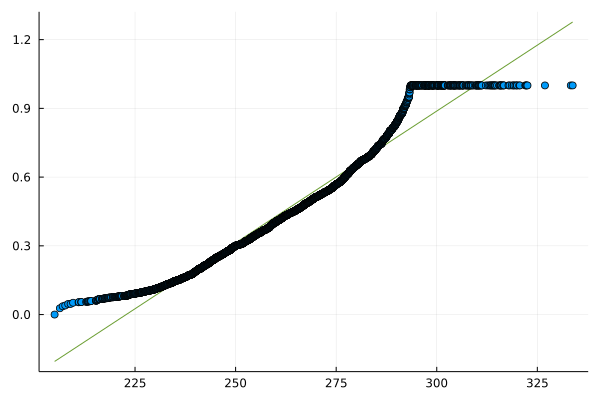

In [53]:
Plots.plot(
 qqplot(sorted_l1_preds[:], sorted_test_targets[:], qqline = :fit), # qqplot of two samples, show a fitted regression line
)

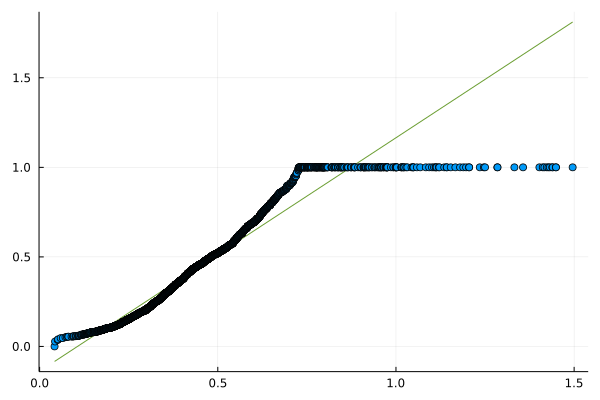

In [52]:
Plots.plot(
qqplot(sorted_l2_preds[:], sorted_test_targets[:], qqline = :fit), # qqplot of two samples, show a fitted regression line
)

### Final $R^2$ Values

In [54]:
print(r_sq_l1)

-1.0998324068082082e6

In [55]:
print(r_sq_l2)

0.8722628864709415

## Conclusion

In [ ]:
# Our results and conclusions of data

#### Complexities

|   | Time Complexity | Space Complexity | Flop Count|
| :----------- | :----------- | :----------- | :----------- |
| **Ridge**  |$ O(n^3) + O(m^2*n) + O(n^2*m) $ | $O(n^2) +O(n*m)$ | $\frac{5}{6}n^3 + (\frac{9}{2}+m)n^2 + n*m^2 + (\frac{5}{6}m)n + m$     |
| **Lasso**  |$ O(m*n*i)$ |$  O(m^2*i) + O(m*n*i)     $|  $i*(2mn + 3m + 3n + 6)$   |
| **Preferred Algorithm** |  Lasso *(Unless i > m > n)*   |  Ridge *(When m > n)*   | Lasso *(Unless: i > m > n)* | 

Our results show that Lasso Regression is the better algorithm when it comes to Time Complexity when the number of iterations of the lasso regression (i) is less than the number of rows (m) and columns (n) from the input data. This is because the term of $O(n*m^2)$ in the Ridge regression will be its largest term when m > n (normal case), which would be greater than $O(m*n*i)$. However, in cases where "i" is large, ridge regression will outperform lasso in time complexity.

When it comes to Space Complexity, Ridge regression uses less memory when the number of data points in the input matrix (m) is greater than the number of features. This should occur for most cases.

In addition, Lasso and Ridge appear to be similar when it comes to floating point operations. If the number of rows is a larger value than n or i, Lasso will easily calculate less FLOPS due to not needing to use Gaussian Elimination to find the inverse of a large matrix. However, if the number of iterations (i) is larger than the number of rows (m), and the number of rows is greater than the number of features (n), the ridge regression will perform fewer floating point operations.

**Complexity Results:**

Lasso regression beats ridge regression in time complexity and the number of floating point operations it computes when its number of iterations (i) is lower than the number of data entries (m). Otherwise, Ridge regression wins on Time, Space, and Number of Flops.

Also, in all cases except where the number of data features is greater than data entries (not common), ridge regression will use significantly less space than lasso regression.